# Setup

In [15]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
options(warn = -1)
require("pacman")
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast, aod, tseries)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

# Exploration

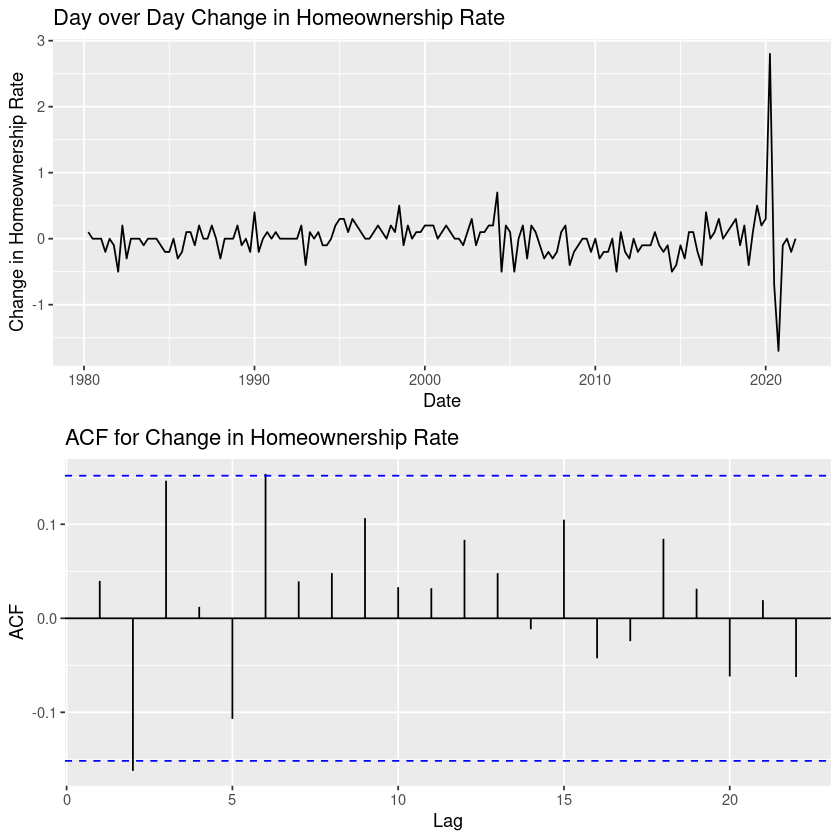

In [7]:
homeownership <- read_homeownership()
homeownership_diff <- homeownership %>% mutate(Value = c(NA,diff(Value))) %>% drop_na

p1 <- homeownership_diff %>% ggplot() +
    geom_line(aes(x = Date, y = Value)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(homeownership_diff$Value) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

# Training ARIMA

In [9]:
test_split = 4
train <- head(homeownership_diff, -test_split)
test <- tail(homeownership_diff, test_split)

In [10]:
arima_comp <- find_best_arima(train$Value, 0:5, 0:2, 0:5)
head(arima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,0,4,86.75047
2,5,1,5,91.42036
3,5,1,1,92.86274
4,5,1,2,94.36783
5,3,0,3,95.55478
6,2,1,4,95.75151



	Box-Ljung test

data:  residuals(model)
X-squared = 2.2186, df = 1, p-value = 0.1364


	Box-Ljung test

data:  residuals(model)^2
X-squared = 3.5294, df = 1, p-value = 0.06029



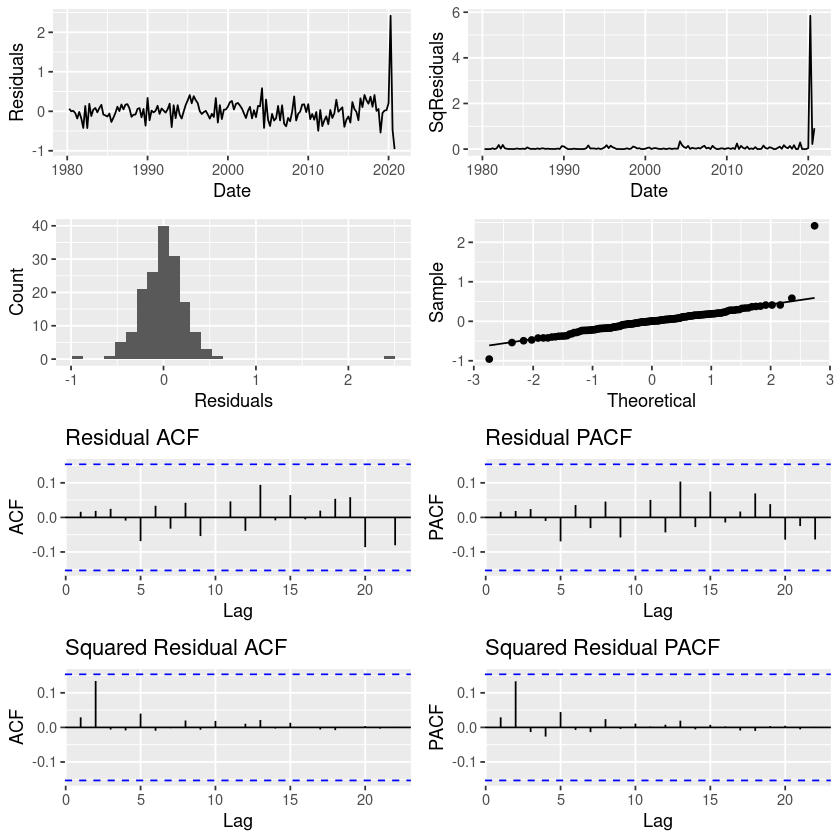

In [11]:
best_order <- as.numeric(arima_comp[1,1:3])
arima_model <- arima(train$Value, order = best_order, method = "ML", optim.control = list(maxit = 1000))
residual_analysis(arima_model, train$Date)
box_tests(arima_model, best_order[1] + best_order[3])

# Training ARMA-GARCH

In [12]:
ugarch_comp <- find_best_ugarch(homeownership_diff$Value, best_order[1], best_order[3], 0:5, 0:5, 0:2, 0:2, test_size = test_split)
head(ugarch_comp$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,3,3,1,0,-0.109852754
2,3,3,0,1,-0.020907991
3,3,3,1,1,-0.015872102
4,3,3,2,0,-0.012585523
5,3,3,0,0,-0.004413106
6,3,3,1,2,0.015272563



	Box-Ljung test

data:  residuals(model)
X-squared = 23.217, df = 1, p-value = 1.447e-06


	Box-Ljung test

data:  residuals(model)^2
X-squared = 36.133, df = 1, p-value = 1.843e-09



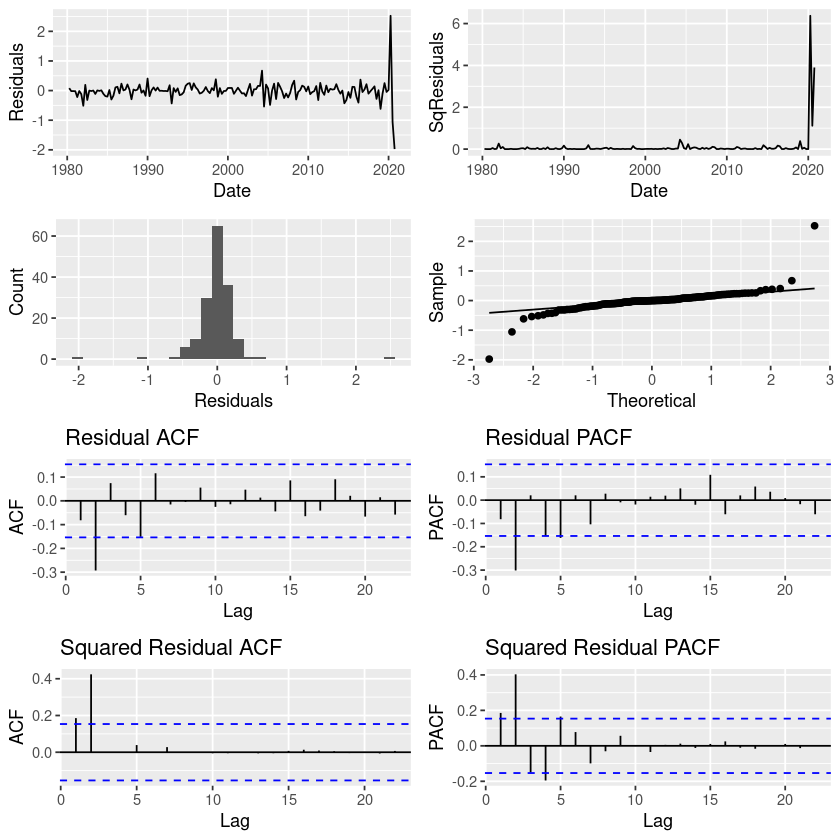

In [17]:
best_order <- ugarch_comp$Final[1,1:4] %>% as.numeric
spec <- ugarchspec(variance.model=list(garchOrder=c(best_order[3:4])),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model <- ugarchfit(spec, homeownership_diff$Value, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model, train$Date)
box_tests(ugarch_model, sum(best_order))

# Forecasting

## ARIMA

PM =  90.87818

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.5155736,0.790435,0.736569,-Inf,Inf


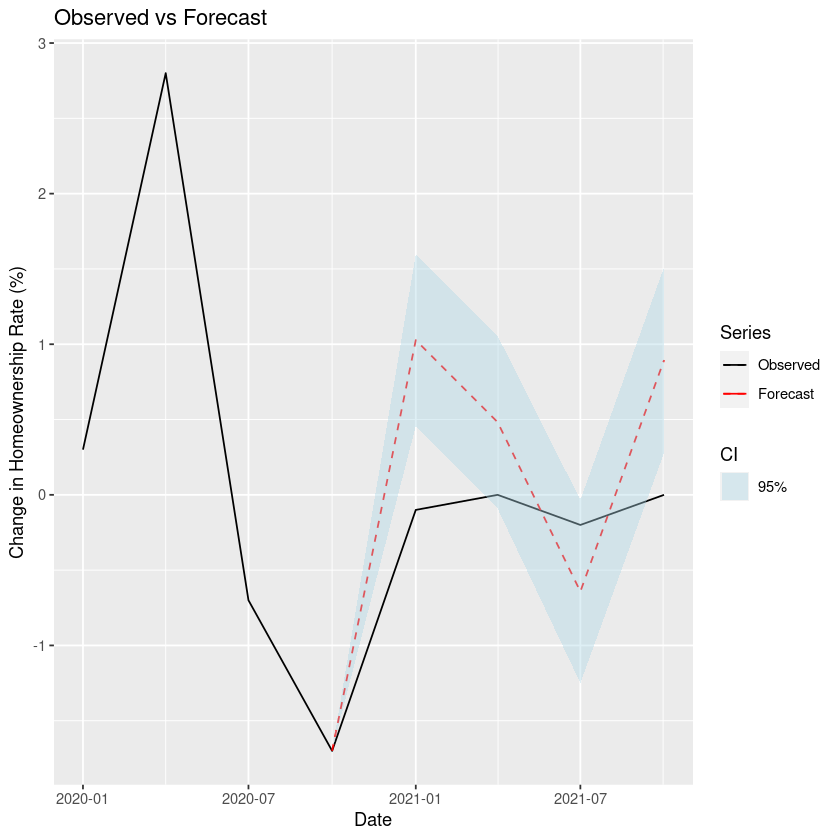

In [18]:
arima_fc <- forecast_arima(arima_model, homeownership_diff$Date, homeownership_diff$Value, test_split, 95,
                    y_lab = "Change in Homeownership Rate (%)")
arima_fc$plot
fc_data <- tail(arima_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## ARMA-GARCH

PM =  23.80735

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.4003834,0.4045683,0.4003834,-Inf,Inf


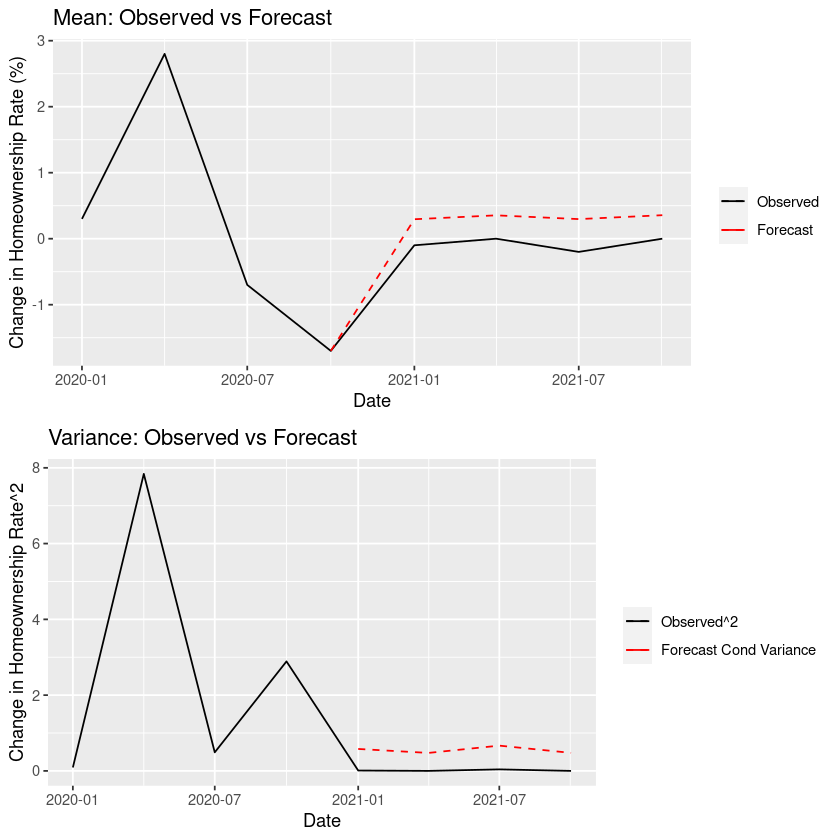

In [20]:
ugarch_fc <- forecast_ugarchroll(ugarch_model, homeownership_diff$Date, test$Value, test_split,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
ugarch_fc$plot
fc_data <- tail(ugarch_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

# Undifferenced Reconstruction

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.491779,1.539386,1.491779,-2.277818,2.277818


,ME,RMSE,MAE,MPE,MAPE
Test set,-0.9976145,1.099158,0.9976145,-1.524072,1.524072


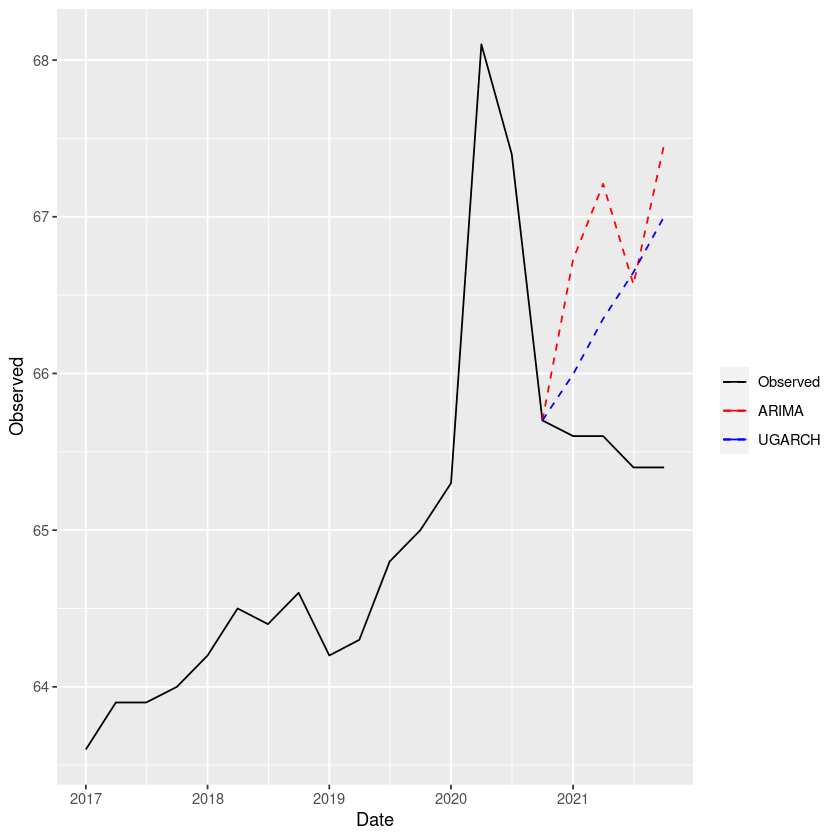

In [26]:
arima_recon <- diffinv(c(train$Value, tail(arima_fc$data$Forecast, test_split)),
                       xi = homeownership$Value[1])
ugarch_recon <- diffinv(c(train$Value, tail(ugarch_fc$data$Forecast, test_split)),
                        xi = homeownership$Value[1])
combined_recon <- data.frame(Date = homeownership$Date,
                            Observed = homeownership$Value,
                            ARIMA = arima_recon,
                            UGARCH = ugarch_recon)

combined_recon %>% tail(20) %>% ggplot() +
  geom_line(aes(x = Date, y = Observed, color = "Observed")) +
  geom_line(data = tail(combined_recon, test_split + 1), aes(x = Date, y = ARIMA, color = "ARIMA"), linetype = "dashed") +
  geom_line(data = tail(combined_recon, test_split + 1), aes(x = Date, y = UGARCH, color = "UGARCH"), linetype = "dashed") +
  scale_color_manual("", values = c("Observed" = "black", "ARIMA" = "red",
                                    "UGARCH" = "blue"))

fc_only <- tail(combined_recon, test_split)

accuracy(fc_only$ARIMA, x = fc_only$Observed)
accuracy(fc_only$UGARCH, x = fc_only$Observed)